# NLP Coursework - LASER Test


## Import data and transform to LASER embeddings

In [5]:
# Imports
import requests
import numpy as np
from nltk.corpus import stopwords
from nltk import download

In [8]:
# Test if LASER service is working
def get_vect(query_in, lang = 'en', address = '127.0.0.1:8050'):
    url = "http://" + address + "/vectorize"
    params = {"q": query_in, "lang": lang}
    resp = requests.get(url=url, params=params).json()
    return resp["embedding"]

# Test to get vector embeddings
input_dict = {
    "en":"Machine learning isn't as hard as people think.",
    "de":"Maschinelles Lernen ist nicht so schwer wie die Leute denken.",
}

embedded_dict = {}
for key in input_dict:
    embedded_dict[key] = np.array(get_vect(input_dict[key], lang = key))
    
from sklearn.metrics.pairwise import cosine_similarity
cos_lib = cosine_similarity(embedded_dict['de'], embedded_dict['en'])

print(cos_lib)

[[0.93503236]]


In [9]:
# Get training and validation data
f_train_scores = open("./train.ende.scores",'r')
de_train_scores = f_train_scores.readlines()

f_train_scores_VAL = open("./dev.ende.scores",'r')
de_train_scores_VAL = f_train_scores_VAL.readlines()

print()

In [2]:
# Stopwords
#downloading stopwords from the nltk package
download('stopwords') #stopwords dictionary, run once

stop_words_en = set(stopwords.words('english'))
stop_words_de = set(stopwords.words('german'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/group-59/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
# Get LASER vectors for training
file_de = open("./train.ende.src") 
file_en = open("./train.ende.mt") 

file_de_VAL = open("./dev.ende.src") 
file_en_VAL = open("./dev.ende.mt") 

files = [{"name": "training_LASER_embeddings", "file_de": file_de, "file_en": file_en},
         {"name": "validation_LASER_embeddings", "file_de": file_de_VAL, "file_en": file_en_VAL}]

for file in files:
    lines_en = file["file_de"].readlines() 
    lines_de = file["file_en"].readlines()

    # Remove stopwords
    for i in range(len(lines_de)):
        querywords = lines_en[i].split()
        resultwords_en  = [word.lower() for word in querywords if word.lower() not in stop_words_en]
        result_en = ' '.join(resultwords_en)
        lines_en[i] = result_en

        querywords = lines_de[i].split()
        resultwords_de  = [word.lower() for word in querywords if word.lower() not in stop_words_de]
        result_de = ' '.join(resultwords_de)
        lines_de[i] = result_de

    en_LASER_embeddings = []
    de_LASER_embeddings = []

    for i in range(len(lines_en)):
        print(str(i) + ", ", end="", flush=True)

        a = np.array(get_vect(lines_de[i], lang = 'de'))
        b = np.array(get_vect(lines_en[i], lang = 'en'))

        de_LASER_embeddings.append(a)
        en_LASER_embeddings.append(b)

    # Save numpy arrays
    path_de = 'de_' + file["name"] + '.npy'
    path_en = 'en_' + file["name"] + '.npy'
    
    np.save(path_de, de_LASER_embeddings)
    np.save(path_en, en_LASER_embeddings)

### Try predicting scores with a simple linear model

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        
        self.fc1 = nn.Linear(1024*2, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 32)
        self.fc4 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        return self.fc4(x)

In [396]:
from torch.utils.data import Dataset, DataLoader

# Embeddings to Tensors
# Dataloaders
embeddings_de = np.load('de_LASER_embeddings_0_to_1000.npy')
embeddings_en = np.load('en_LASER_embeddings_0_to_1000.npy')

embeddings_de_VAL = np.load('de_LASER_embeddings_VAL_ALL.npy')
embeddings_en_VAL = np.load('en_LASER_embeddings_VAL_ALL.npy')

embeddings = []
embeddings_VAL = []

for i in range(len(embeddings_de)):
    embeddings.append(np.concatenate((embeddings_de[i], embeddings_en[i])))
    
for i in range(len(embeddings_de_VAL)):
    embeddings_VAL.append(np.concatenate((embeddings_de_VAL[i][0], embeddings_en_VAL[i][0])))

class LASER_Dataset(Dataset):
    def __init__(self, embeddings, scores):
        self.embeddings = torch.tensor(embeddings).float()
        self.scores = torch.tensor(scores).float()

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, item):
        return {'embedding': self.embeddings[item], 'score': self.scores[item]}

# Load scores
scores = [float(val) for val in de_train_scores]
scores_VAL = [float(val) for val in de_train_scores_VAL]

batch_size = 20
dataset_train = LASER_Dataset(embeddings, scores)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

dataset_VAL = LASER_Dataset(embeddings_VAL, scores_VAL)
dataloader_VAL = torch.utils.data.DataLoader(dataset_VAL, batch_size=batch_size, shuffle=False)

In [416]:
def check_on_test():
    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        for i in range(len(embeddings_VAL)):
            emb = embeddings_VAL[i]
            tens = torch.tensor(emb).float().to(device)
            pred_score = model(tens)
            
            real_score = torch.tensor(scores_VAL[i]).float().view(1).to(device)
            
            loss = criterion(pred_score, real_score)
            total_loss += loss.item()
    
    return total_loss / len(embeddings_VAL)

In [451]:
# Optimizer
model = SimpleNet()
model = model.to(device=device)  # move the model parameters to CPU/GPU
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

In [17]:
epochs = 50

training_losses = []
test_losses = []

for e in range(epochs):
    #print("Epoch " + str(e))
    total_epoch_loss = 0
    total_epoch_loss_test = 0

    for batch_idx, batch_samples in enumerate(dataloader_train):
        model.train()  # put model to training mode
        
        emb, score = batch_samples['embedding'].to(device), batch_samples['score'].to(device)

        pred_score = model(emb).view(-1)
        # print(pred_score)
        
        loss = criterion(pred_score, score)
        
        # Zero out all of the gradients for the variables which the optimizer
        # will update.
        optimizer.zero_grad()
        
        # This is the backwards pass: compute the gradient of the loss with
        # respect to each  parameter of the model.
        loss.backward()

        # Actually update the parameters of the model using the gradients
        # computed by the backwards pass.
        optimizer.step()
        
        total_epoch_loss += loss.item()
    
    training_losses.append(total_epoch_loss)
    test_loss = check_on_test()
    test_losses.append(test_loss)
    print(str(total_epoch_loss) + " // " + str(test_loss))

-0.0031516516094057256


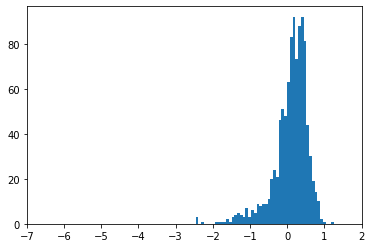

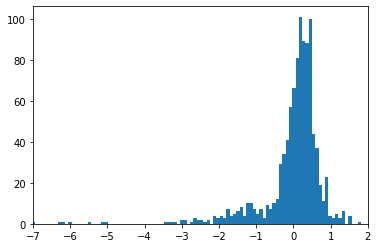

In [421]:
# Evaluate
predicted = []

model.eval()

with torch.no_grad():
    for i in range(len(embeddings_VAL)):
        emb = embeddings_VAL[i]
        tens = torch.tensor(emb).float().to(device)
        pred_score = model(tens).item()
        predicted.append(pred_score)


pearson = pearsonr(predicted, scores_VAL[:len(embeddings_VAL)])[0]
print(pearson)

plt.figure()
plt.hist(predicted, bins=50)
plt.xlim([-7, 2])

plt.figure()
plt.hist(scores_VAL[:len(embeddings_VAL)], bins=100)
plt.xlim([-7, 2])
plt.show()

### sci-kit Linear model

In [ ]:
# Try a simple linear model
from sklearn.linear_model import LinearRegression

reg = LinearRegression()
X = embeddings
y = scores[:len(embeddings)]

reg.fit(X, y)

pred = reg.predict(embeddings_VAL)

actual = scores_VAL


fig, ax = plt.subplots()
ax.scatter(actual, predicted)
ax.set_xlim([-7, 3])
ax.set_ylim([-7, 3])
ax.set_xlabel('Real Age')
ax.set_ylabel('Predicted Age')